In [49]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import ETD_KT_CM_JAX_Vectorised, ic, KS_params, KDV_params
from filters import resamplers
from filters.filter import ParticleFilter


In [50]:
signal_params = ConfigDict(KS_params)
signal_params.update(E=1)
ensemble_params = ConfigDict(KS_params)
ensemble_params.update(E=100)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = ic(signal_model.x, signal_params.E)
initial_ensemble = ic(ensemble_model.x, ensemble_params.E) 
#initial_ensemble += 0.1 * jax.random.normal(jax.random.PRNGKey(56), initial_ensemble.shape)

available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)


multinomial, systematic, no_resampling, default


In [51]:
resampling = 'systematic'

pf = ParticleFilter(
    n_particles = ensemble_params.E,
    n_steps = 100,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = 0.1,
    seed = 11,
    resampling=resampling,
)

In [52]:
final, all = pf.run(initial_ensemble, initial_signal, 10)

In [53]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal
#out shape is (n_total, n_particles, n_dim)

<class 'tuple'>
2
(10, 100, 256)
(10, 1, 256)


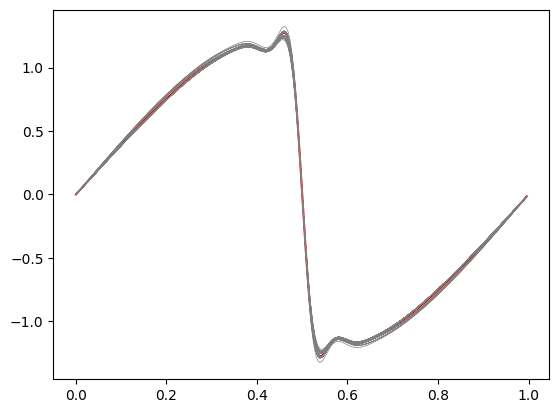

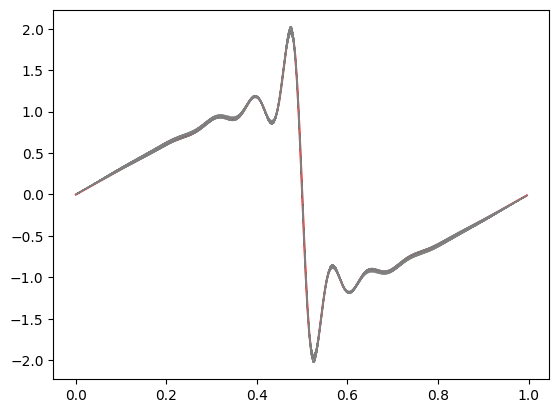

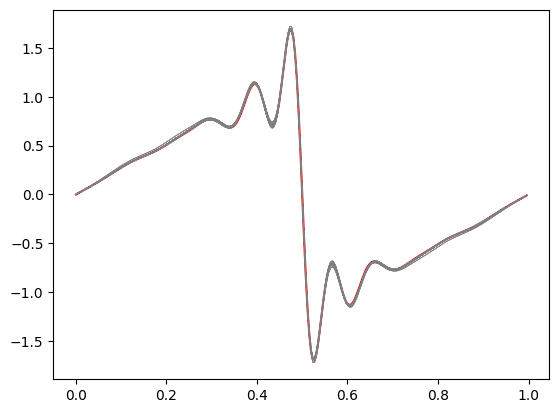

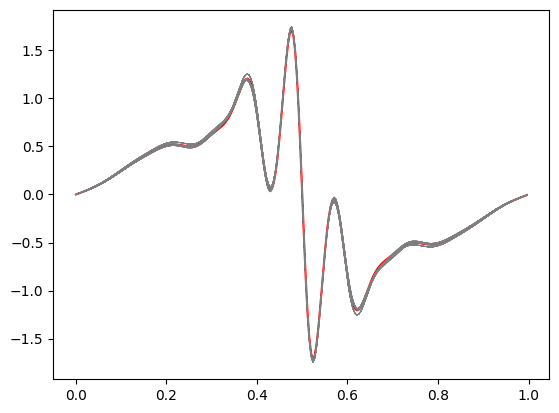

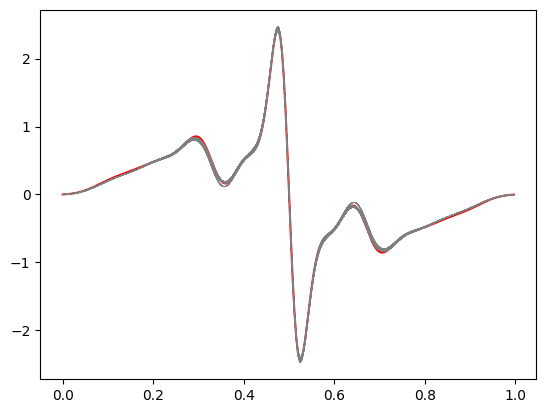

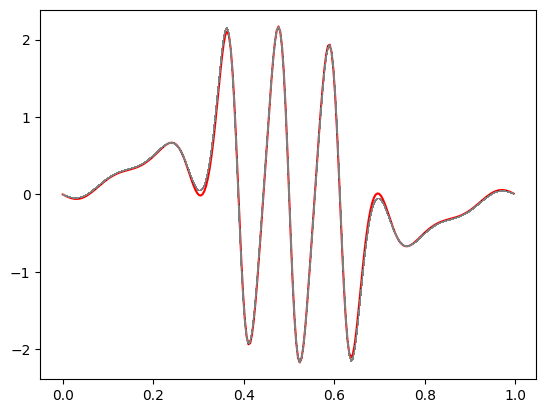

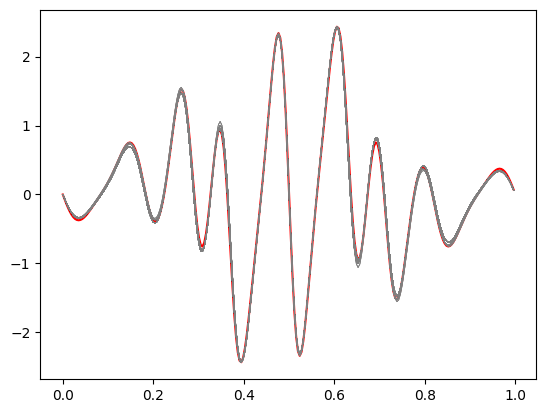

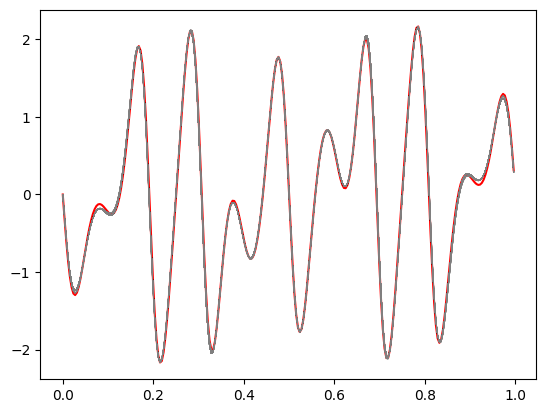

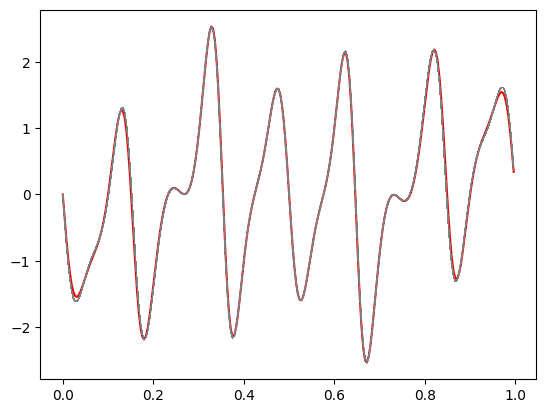

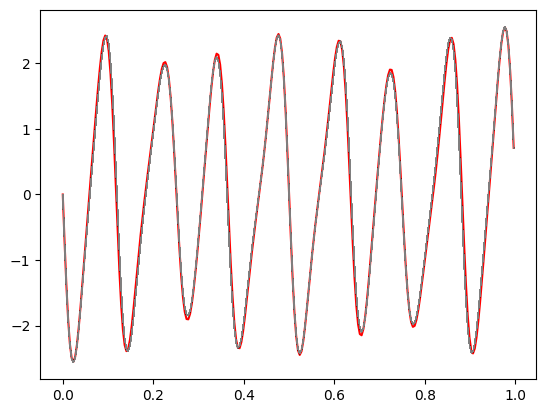

In [54]:
for i in range(10):
    plt.plot(signal_model.x, all[1][i,0,:], color='red')
    plt.plot(signal_model.x, all[0][i,:,:].T, color='grey', linewidth=0.5)
    plt.show()
    